# **Jour 44 : USArrests**

Le jeu de données **USArrests** est un ensemble de statistiques classiques qui fournit des informations sur la criminalité et le nombre d'arrestations dans chacun des **50** États américains en **1973** pour **100 000** habitants.

$\bigoplus$ **Signification des variables**

+  Murder :	Taux d'homicides volontaires (meurtres)	
+  Assault :	Taux d'agressions physiques (violentes)	
+  UrbanPop :	Pourcentage de la population vivant en zone urbaine
+  Rape :	Taux de viols déclarés	

## 0. Chargement des librairies 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import plotly.express as px
import statsmodels.api as sm


from sklearn.model_selection import train_test_split, cross_val_score

## 1. Chargement de la base de données

In [3]:
data = pd.read_csv("../data/USArrests.csv")

data.columns.values[0]= 'Etats' #Pour nommer la première colonne 'Etats' 

In [4]:
data.head()

,Etats,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## 2. Vérification des valeurs manquantes et quelques statistiques  descriptives

### 2.1. Les valeurs manquantes 


In [5]:
print(data.isnull().sum())

Etats       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


Aucune valeur manquante ne se trouve dans la base.

### 2.2. Statistiques Descriptives

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


Avec la variable **UrbanPop** par exemple, si on devrait avoir la même proportion de population vivant en zone urbaine dans chaque Etat, alors ce serait **65,54%** et les valeurs de notre échantillon s'écartent en moyenne de **14,47 unités** par raport à cette dernière. Ou encore si on devrait avoir le même taux d'aggressions physiques dans chaque Etat, ça serait **170,76 pour 100 000 habitants** et les valeurs s'écartent en moyenne de **83,33** unités par rapport à cette moyenne, pour la variable **Assault**.

### 3. Explorations visuelle 

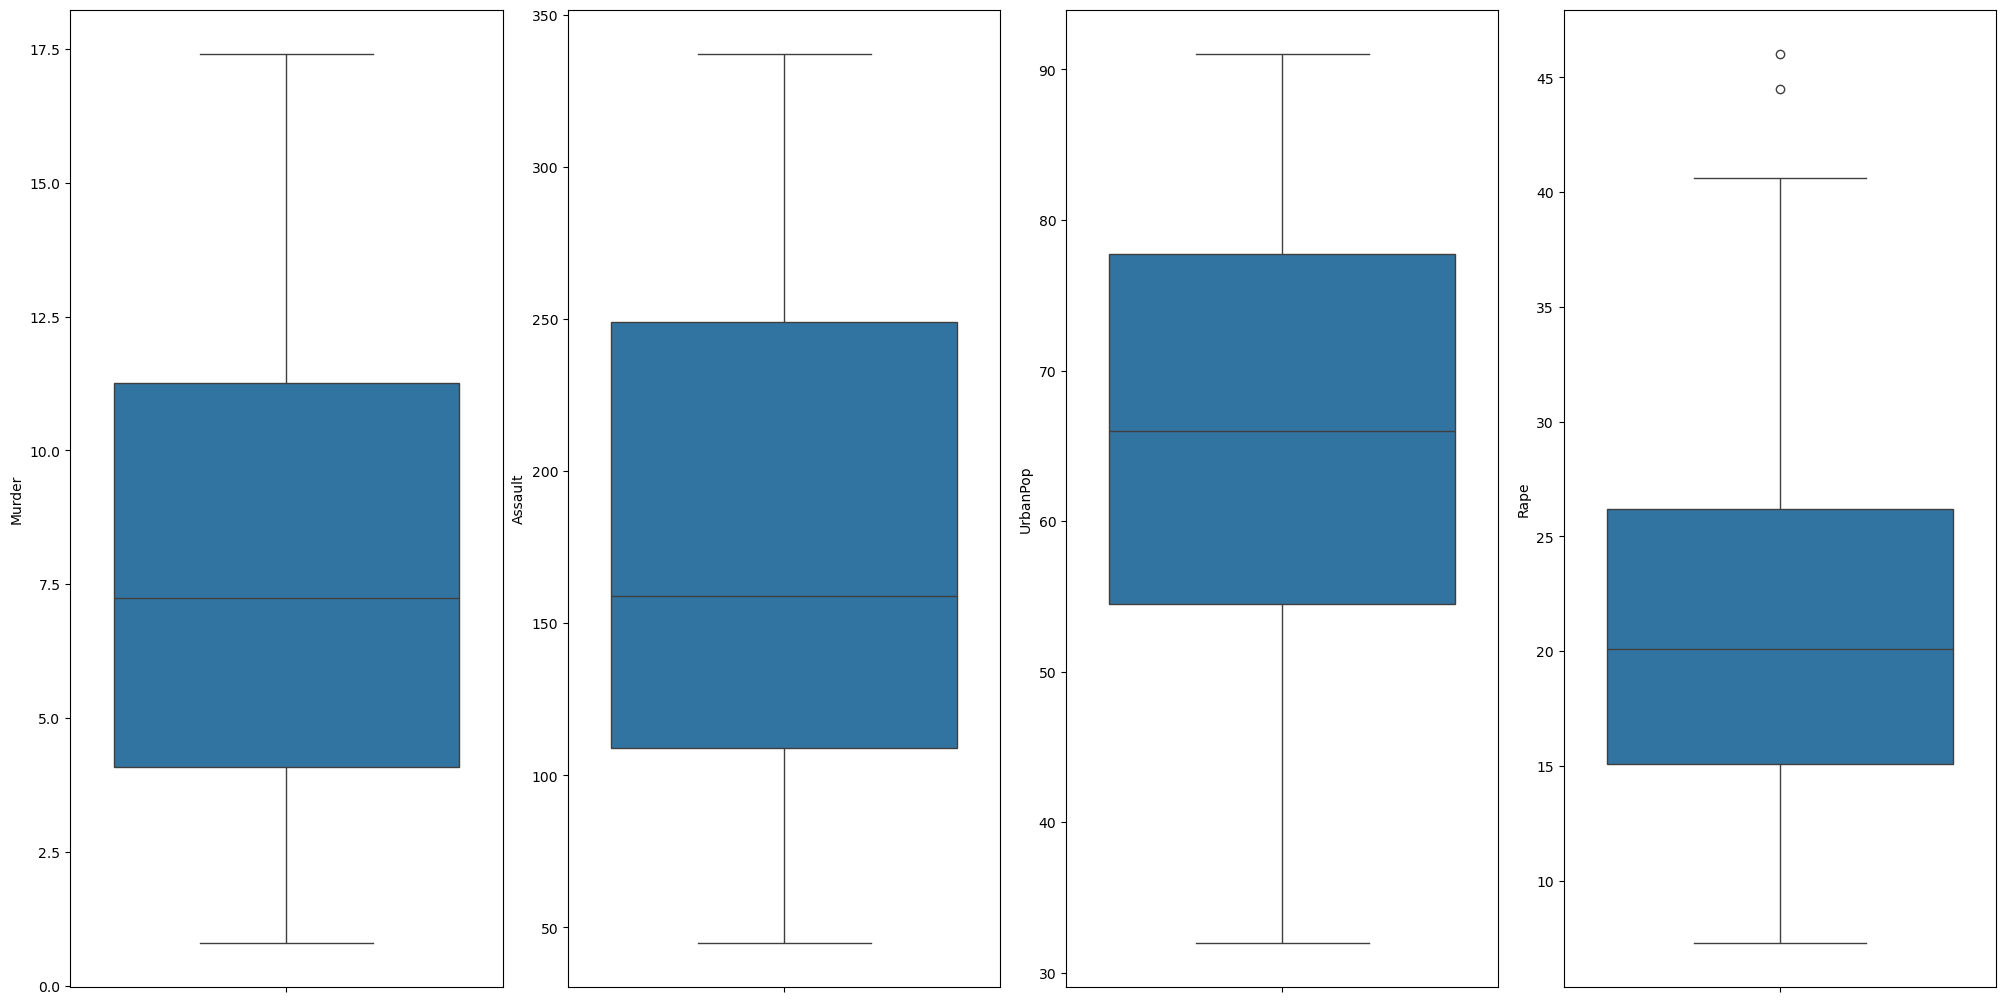

In [7]:
# Nous allons exclure la colonne des noms des Etats pour les analyses
df = data.select_dtypes(include=[np.number])
# Création de boxplots
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

Ici nous observons sur ces boxplots juste 2 valeures aberrantes sur la variable **Rape**. Cela ne devrait pas poser de problème pour la suite de notre analyse.

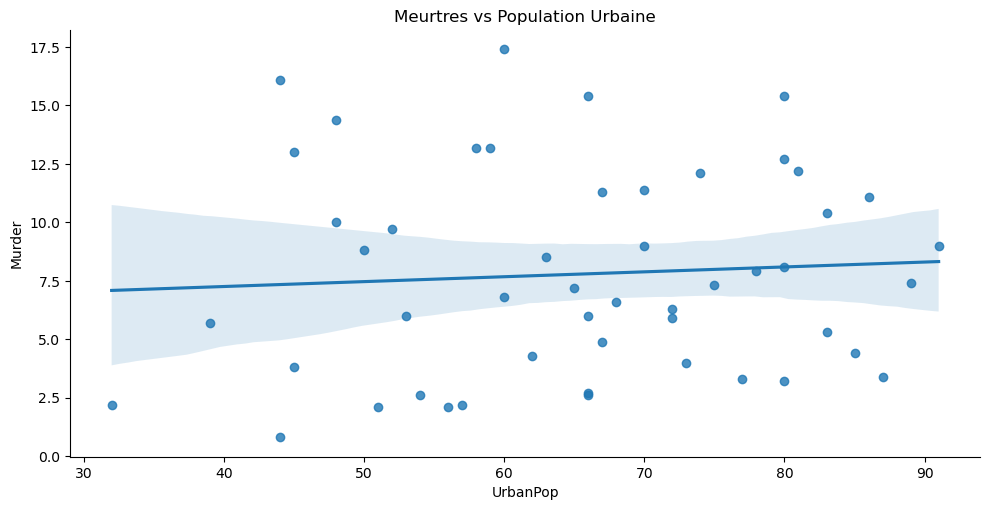

In [8]:
sns.lmplot(data=df, x='UrbanPop', y='Murder', height=5, aspect=2)
plt.title("Meurtres vs Population Urbaine")
plt.show()

Ici on peut simplement remarquer qu'il n'y a aucune relation particulière entre la proportion de la population vivant en zone urbaine et les meutres enregistrés dans un quelconque Etat.

Text(0.5, 1.0, 'Distribution des Arrestations pour Agressions (1973)')

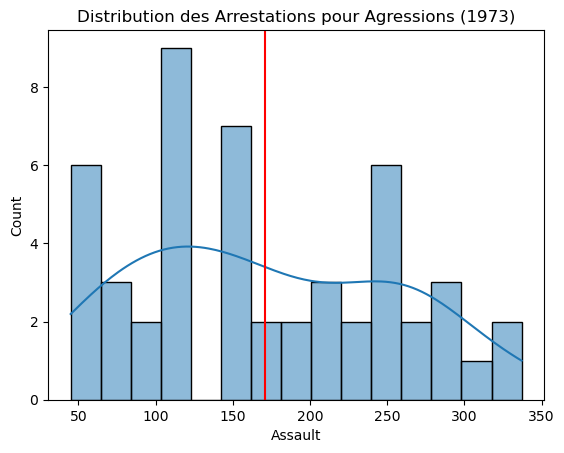

In [9]:
sns.histplot(df['Assault'], kde=True, bins=15)
plt.axvline(170.76, color='red', label='Moyenne')
plt.title("Distribution des Arrestations pour Agressions (1973)")

La majorité de ces Etats ont des taux d'aggressions compris entre 50 et 150 et quelques un avec des taux élevés (250 - 350). La position de la ligne rouge par rapport au pic de la ligne bleu veut simplement dire que la moyenne est tirée par ces quelques Etats aux taux d'aggressions élevés malgré leur faible effectif.

## 4. Modélisation 

### 4.1. Préparation des données

In [10]:
def train(model, X, y):
    # Entraînement du modèle
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model.fit(X_train, y_train)
    
    # Prédiction sur les données d'entraînement
    pred = model.predict(X_test)
    
    # Validation croisée du modèle
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print("Rapport du modèle")
    print("RMSE :",np.sqrt(mean_squared_error(y_test, pred)))
    print("R2 :", r2_score(y_test, pred))
    print('CV Score :', cv_score)

### 4.2. Régression linéaire 

In [13]:
# les variables explicatives (X) et la variable cible (y)
X = df.drop(columns=["Murder"])  
y = df["Murder"]

# Initialisation du modèle
model = LinearRegression()

# Ajustement du modèle
train(model, X, y)

Rapport du modèle
RMSE : 2.061151087957611
R2 : 0.6954708507453577
CV Score : 7.11369377843057


## 5. Prédiction

Que prévoir pour un état avec Assault = 150, UrbanPop = 70 et Rape = 20 ?

In [12]:
new_data = pd.DataFrame({'Assault': [150], 'UrbanPop': [70], 'Rape': [20]})
predicted_murder = model.predict(new_data)[0]
print(f"Taux de meurtre prévu: {predicted_murder:.2f}")

Taux de meurtre prévu: 6.54


R² = 0.6954 alors le modèle explique 76.6% de la variance du taux de meurtres et une RMSE = 2.00 indique que l'erreur moyenne des prédictions est de 2 meurtres pour 100k habitants.

Pour Assault = 150, UrbanPop = 70%, Rape = 20, le modèle prédit 6.54 meurtres pour 100.000 habitants. Cela correspond à un État moins violent que la moyenne. Notre modèle a une bonne puissance prédictive avec une précision acceptable donc on peut valider cette prédiction. 